<a href="https://colab.research.google.com/github/evelinafischer/AH2179/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Traffic Flow Short-Term Prediction

##1. Data Preprocessing

###1.1 Load the Data

In [1]:
#Import pandas for data handling and analysis
import pandas as pd
#Import numpy for numerical operations
import numpy as np

#Read the CSV file into a pandas DataFrame, using semicolon as the column separator
data_df = pd.read_csv("training_dataset.csv",sep=";")
#Display the contents of the DataFrame
data_df

,DP_ID,PORTAL,Date,Time,Interval_1,Interval_5,Interval_15,Interval_30,Interval_60,SPEED_MS_AVG,FLOW
0,351,"E4S 56,490",20210601,00:00:00,0,0,0,0,0,17.50,1.0
1,539,"E4S 56,160",20210601,00:00:00,0,0,0,0,0,22.35,2.0
2,4473,"E4S 58,140",20210601,00:00:00,0,0,0,0,0,22.22,2.0
3,4439,"E4S 57,820",20210601,00:00:00,0,0,0,0,0,21.94,3.0
4,4430,"E4S 57,435",20210601,00:00:00,0,0,0,0,0,22.22,4.0
...,...,...,...,...,...,...,...,...,...,...,...
7471041,4439,"E4S 57,820",20211231,23:59:00,1439,287,95,47,23,18.33,1.0
7471042,4428,"E4S 57,820",20211231,23:59:00,1439,287,95,47,23,19.17,4.0
7471043,4430,"E4S 57,435",20211231,23:59:00,1439,287,95,47,23,18.61,6.0
7471044,4437,"E4S 57,435",20211231,23:59:00,1439,287,95,47,23,20.00,3.0


###1.2 Dataset Overview

In [3]:
#Check the shape of the dataset
data_df.shape

(7471046, 11)

In [4]:
#General info about dataset
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7471046 entries, 0 to 7471045
Data columns (total 11 columns):
 #   Column        Dtype  
---  ------        -----  
 0   DP_ID         int64  
 1   PORTAL        object 
 2   Date          int64  
 3   Time          object 
 4   Interval_1    int64  
 5   Interval_5    int64  
 6   Interval_15   int64  
 7   Interval_30   int64  
 8   Interval_60   int64  
 9   SPEED_MS_AVG  float64
 10  FLOW          float64
dtypes: float64(2), int64(7), object(2)
memory usage: 627.0+ MB


In [5]:
#Count how many unique portals exist
print("Unique PORTALs:", data_df["PORTAL"].nunique())

Unique PORTALs: 8


In [6]:
#Count how many unique sensors exist
print("Unique DP_IDs:", data_df["DP_ID"].nunique())

Unique DP_IDs: 29


###1.3 Missing Values

In [7]:
#Select rows where at least one column has NaN
nan_rows = data_df[data_df.isna().any(axis=1)]

#Number of rows with at least one NaN
print(f"Number of rows with at least one NaN: {len(nan_rows)}")

Number of rows with at least one NaN: 180


In [8]:
#Count missing values, NaN, in each column
data_df.isna().sum()

,0
DP_ID,0
PORTAL,0
Date,0
Time,0
Interval_1,0
Interval_5,0
Interval_15,0
Interval_30,0
Interval_60,0
SPEED_MS_AVG,0


In [9]:
#Drop rows with missing FLOW values
data_df = data_df.dropna(subset=['FLOW']).copy()

###1.4 Data Type Conversion

In [10]:
#Convert 'Date' from int to datetime for easier extraction of day, month, and weekday
data_df['Date'] = pd.to_datetime(data_df['Date'], format='%Y%m%d')

#Convert 'Time' from object to datetime.time format, making it easier to filter and analyze specific time periods
data_df['Time_dt'] = pd.to_datetime(data_df['Time'], format='%H:%M:%S').dt.time

#Converting 'PORTAL' to categorical type for modeling purposes
data_df['PORTAL'] = data_df['PORTAL'].astype('category')

##2. Feature Engineering

###2.1 Time-Based Features

In [11]:
#Hour of day
data_df['Hour'] = pd.to_datetime(data_df['Time'], format='%H:%M:%S').dt.hour

#Minute of day
data_df['Minute_of_day'] = data_df['Hour'] * 60 + pd.to_datetime(data_df['Time'], format='%H:%M:%S').dt.minute

#Weekday
data_df['Weekday'] = data_df['Date'].dt.dayofweek

#Weekend flag
data_df['Is_weekend'] = data_df['Weekday'] >= 5

In [12]:
#Make sure index is datetime
data_df['Datetime'] = pd.to_datetime(data_df['Date'].astype(str) + " " + data_df['Time'].astype(str))
data_df = data_df.set_index('Datetime')

#Define rush hours (07:30–08:30)
data_df['Is_rushhour'] = (
    ((data_df.index.hour == 7) & (data_df.index.minute >= 30)) |
    ((data_df.index.hour == 8) & (data_df.index.minute <= 30))
)

###2.2 Aggregated Traffic Features and Previous Interval Values

In [13]:
#Code generated with the help of ChatGPT

#Aggregate data to 5-minute intervals per sensor
sensor_agg_5min = (
    data_df.groupby("DP_ID")[["FLOW", "SPEED_MS_AVG"]]
    .resample("5min")  #Resample into 5-minute intervals
    .mean()            #Compute the average FLOW and SPEED_MS_AVG for each interval
    .reset_index()     #Turn the index back into regular columns
)

#Sort by sensor and time to ensure 'previous' values refer to earlier times
sensor_agg_5min = sensor_agg_5min.sort_values(["DP_ID", "Datetime"])

#Define how many rows to shift for each interval
shift_map = {5: 1, 10: 2, 15:3}

#Create features for traffic in the previous 5, 10 and 15 minutes
for minutes, rows in shift_map.items():
    sensor_agg_5min[f"FLOW_previous_{minutes}min"] = sensor_agg_5min.groupby("DP_ID")["FLOW"].shift(rows)

###2.3 Result

In [14]:
#Display the contents of the DataFrame after adding the new features
data_df

,DP_ID,PORTAL,Date,Time,Interval_1,Interval_5,Interval_15,Interval_30,Interval_60,SPEED_MS_AVG,FLOW,Time_dt,Hour,Minute_of_day,Weekday,Is_weekend,Is_rushhour
Datetime,,,,,,,,,,,,,,,,,
2021-06-01 00:00:00,351,"E4S 56,490",2021-06-01,00:00:00,0,0,0,0,0,17.50,1.0,00:00:00,0,0,1,False,False
2021-06-01 00:00:00,539,"E4S 56,160",2021-06-01,00:00:00,0,0,0,0,0,22.35,2.0,00:00:00,0,0,1,False,False
2021-06-01 00:00:00,4473,"E4S 58,140",2021-06-01,00:00:00,0,0,0,0,0,22.22,2.0,00:00:00,0,0,1,False,False
2021-06-01 00:00:00,4439,"E4S 57,820",2021-06-01,00:00:00,0,0,0,0,0,21.94,3.0,00:00:00,0,0,1,False,False
2021-06-01 00:00:00,4430,"E4S 57,435",2021-06-01,00:00:00,0,0,0,0,0,22.22,4.0,00:00:00,0,0,1,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 23:59:00,4439,"E4S 57,820",2021-12-31,23:59:00,1439,287,95,47,23,18.33,1.0,23:59:00,23,1439,4,False,False
2021-12-31 23:59:00,4428,"E4S 57,820",2021-12-31,23:59:00,1439,287,95,47,23,19.17,4.0,23:59:00,23,1439,4,False,False
2021-12-31 23:59:00,4430,"E4S 57,435",2021-12-31,23:59:00,1439,287,95,47,23,18.61,6.0,23:59:00,23,1439,4,False,False


##3. Explorative Data Analysis

In [15]:
#Import matplotlib and seaborn for creating plots and visualizations
import matplotlib.pyplot as plt
import seaborn as sns

###3.1 Distribution Analysis

In [16]:
#Map numeric weekday values (0–6) to actual weekday names
weekday_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday',
               4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

#Create a new column 'Day' in the DataFrame that contains the weekday names
data_df['Day'] = data_df['Weekday'].map(weekday_map)

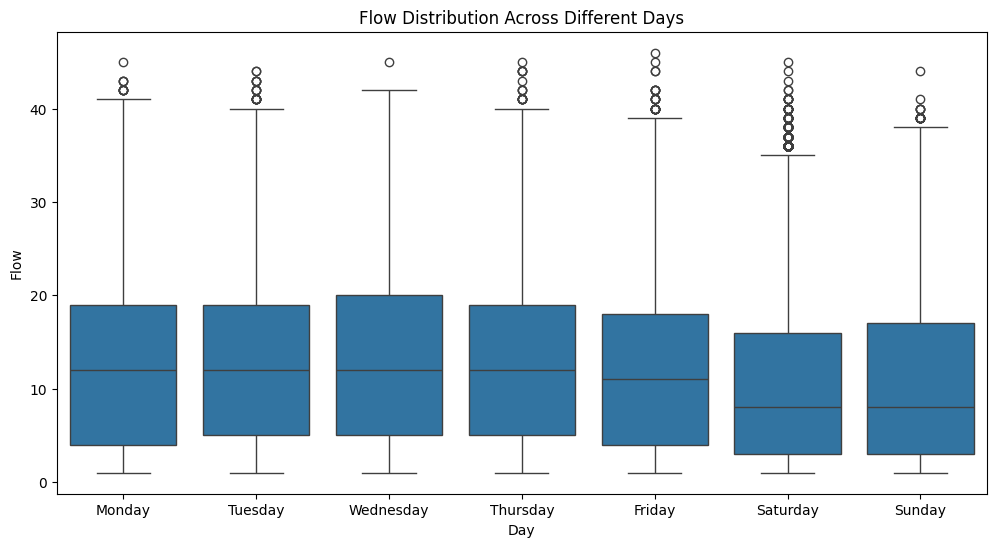

In [17]:
#Flow patterns across different weekdays

#Create a figure for visualizing FLOW distribution across weekdays
plt.figure(figsize=(12, 6))

#Plot a boxplot showing the distribution of FLOW for each weekday
sns.boxplot(
    x='Day',
    y='FLOW',
    data=data_df,
    order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

#Set plot title, x-axis label, y-axis label, and display the plot
plt.title('Flow Distribution Across Different Days')
plt.ylabel('Flow')
plt.xlabel('Day')
plt.show()

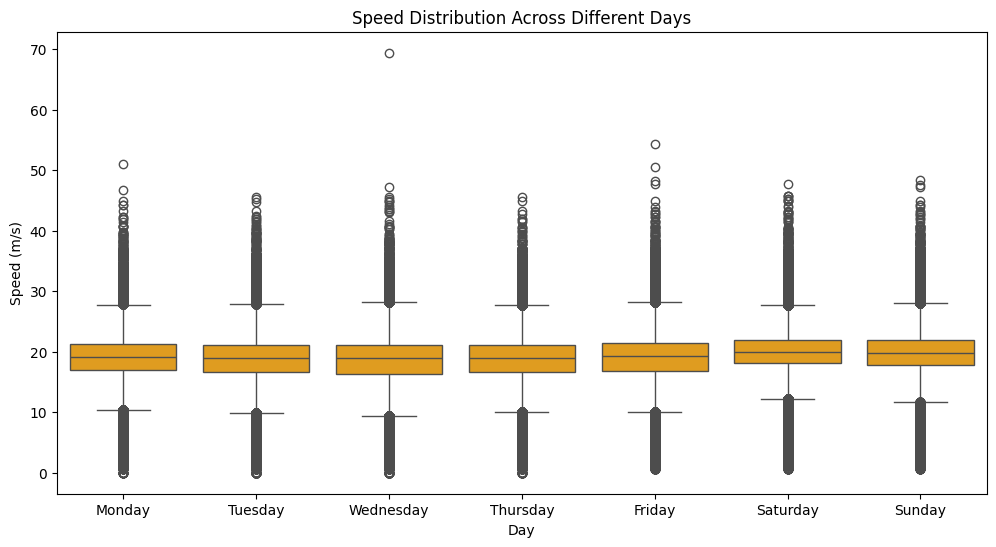

In [18]:
#Speed patterns across different weekdays

#Create a figure for visualizing SPEED_MS_AVG distribution across weekdays
plt.figure(figsize=(12, 6))

#Plot a boxplot showing the distribution of average speed for each weekday
sns.boxplot(
    x='Day',
    y='SPEED_MS_AVG',
    data=data_df,
    color = 'orange',
    order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

#Set plot title, x-axis label, y-axis label, and display the plot
plt.title('Speed Distribution Across Different Days')
plt.ylabel('Speed (m/s)')
plt.xlabel('Day')
plt.show()


###3.2 Temporal Patterns of Traffic Flow and Speed

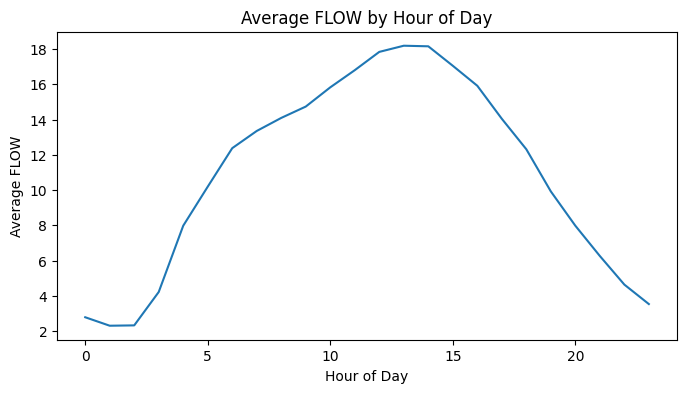

In [19]:
#Average FLOW by hour of day

#Create a figure with a specific size
plt.figure(figsize=(8, 4))

#Plot the average traffic flow (FLOW) for each hour of the day
sns.lineplot(data=data_df, x="Hour", y="FLOW", estimator="mean", errorbar=None)

#Set plot title, x-axis label, y-axis label, and display the plot
plt.title("Average FLOW by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average FLOW")
plt.show()

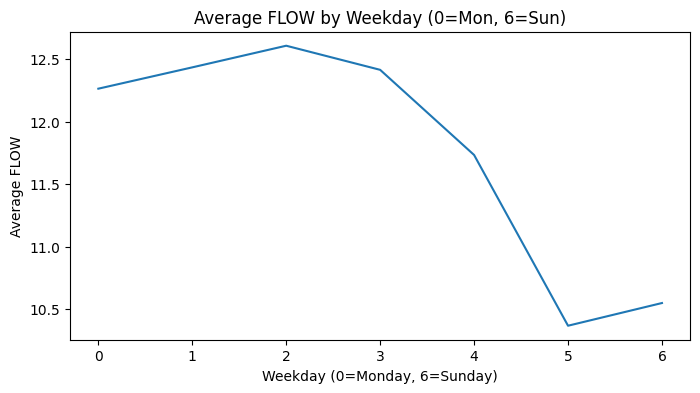

In [20]:
#Average FLOW by weekday

#Create a figure with a specific size
plt.figure(figsize=(8, 4))

#Plot the average traffic flow for each weekday
sns.lineplot(data=data_df, x="Weekday", y="FLOW", estimator="mean", errorbar=None)

#Set plot title, x-axis label, y-axis label, and display the plot
plt.title("Average FLOW by Weekday (0=Mon, 6=Sun)")
plt.xlabel("Weekday (0=Monday, 6=Sunday)")
plt.ylabel("Average FLOW")
plt.show()

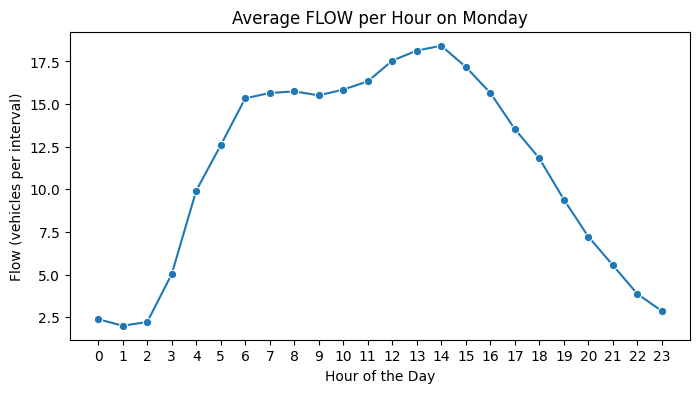

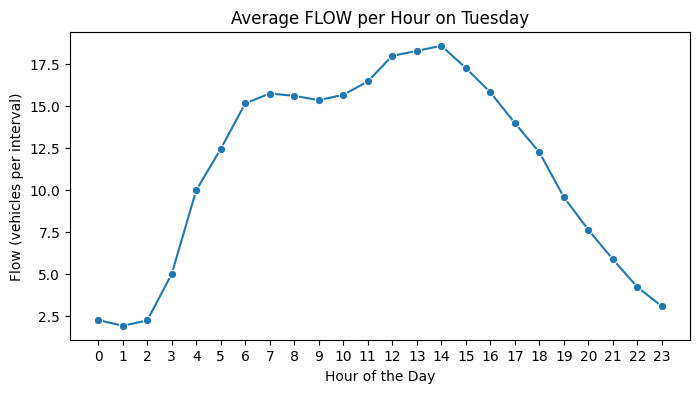

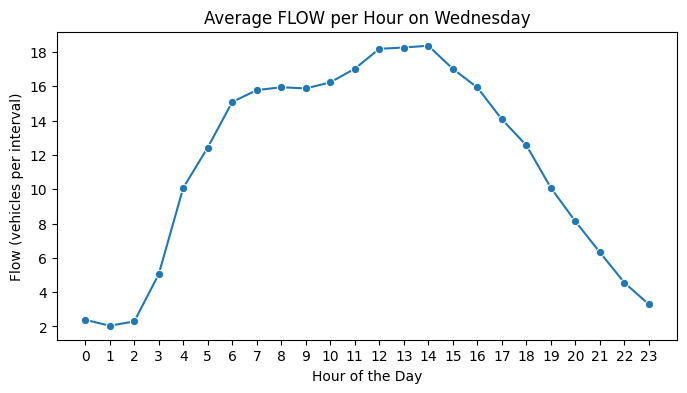

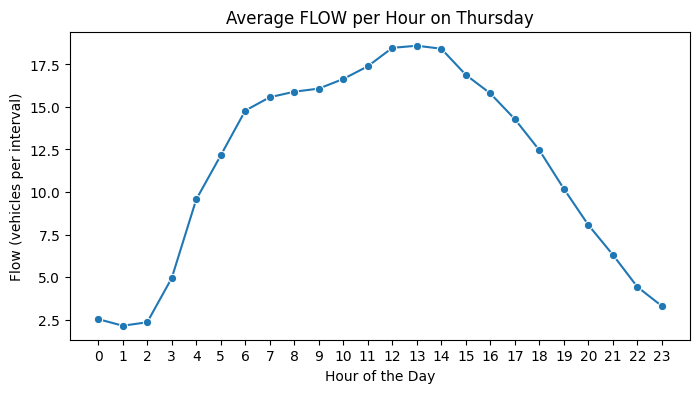

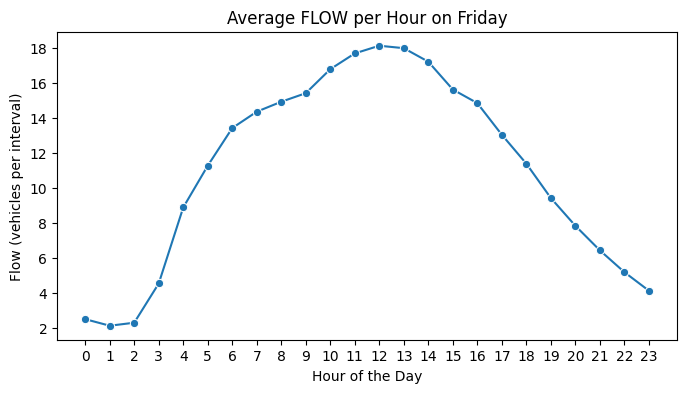

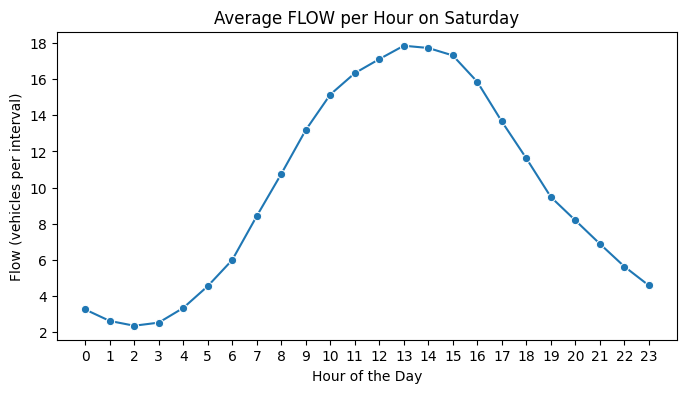

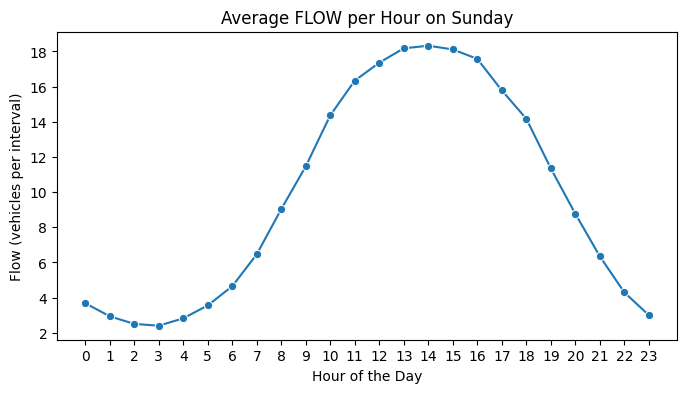

In [21]:
#Average FLOW per hour for each weekday

#Dictionary to map weekday numbers (0-6) to weekday names
weekday_names = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday",
                 4: "Friday", 5: "Saturday", 6: "Sunday"}

#Loop through each weekday (0=Monday, 6=Sunday)
for day in range(7):
    #Filter data for the current weekday
    daily_data = data_df[data_df['Weekday'] == day]
    #Group the filtered data by hour and calculate the mean FLOW for each hour
    flow_per_hour = daily_data.groupby('Hour')['FLOW'].mean()
    #Create a figure with a specific size
    plt.figure(figsize=(8, 4))
    #Plot a line graph of average FLOW per hour for the current weekday
    sns.lineplot(x=flow_per_hour.index, y=flow_per_hour.values, marker='o')
    #Add a title indicating the weekday
    plt.title(f'Average FLOW per Hour on {weekday_names[day]}')
    #Label the x-axis as hour of the day
    plt.xlabel('Hour of the Day')
    #Label the y-axis as flow (vehicles per interval)
    plt.ylabel('Flow (vehicles per interval)')
    #Set x-axis ticks to show each hour from 0 to 23
    plt.xticks(range(0, 24))
    #Display the plot
    plt.show()

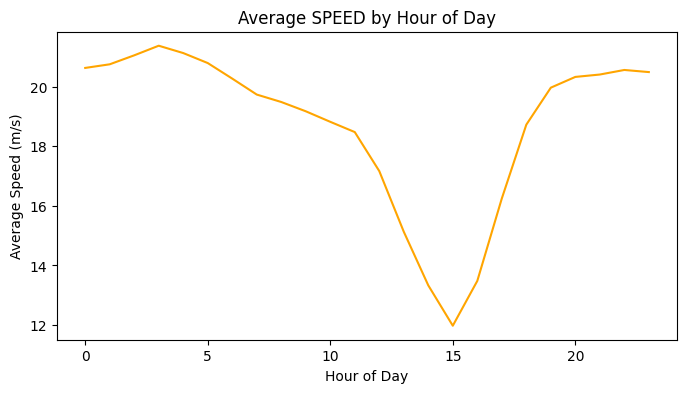

In [22]:
#Average SPEED by hour of day

#Create a figure with a specific size
plt.figure(figsize=(8, 4))

#Plot the average speed (SPEED_MS_AVG) for each hour of the day
sns.lineplot(data=data_df, x="Hour", y="SPEED_MS_AVG", estimator="mean", errorbar=None, color='orange')

#Set plot title, x-axis label, y-axis label, and display the plot
plt.title("Average SPEED by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Speed (m/s)")
plt.show()

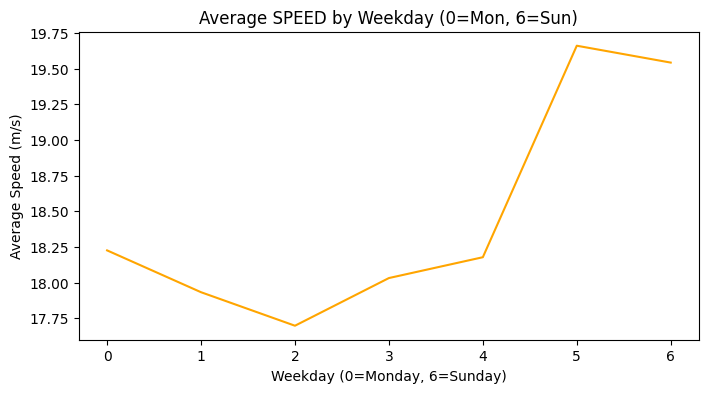

In [23]:
#Average SPEED by weekday (0=Mon, 6=Sun)

#Create a figure with a specific size
plt.figure(figsize=(8, 4))

#Plot the average speed (SPEED_MS_AVG) for each weekday
sns.lineplot(data=data_df, x="Weekday", y="SPEED_MS_AVG", estimator="mean", errorbar=None, color='orange')

#Set plot title, x-axis label, y-axis label, and display the plot
plt.title("Average SPEED by Weekday (0=Mon, 6=Sun)")
plt.xlabel("Weekday (0=Monday, 6=Sunday)")
plt.ylabel("Average Speed (m/s)")
plt.show()

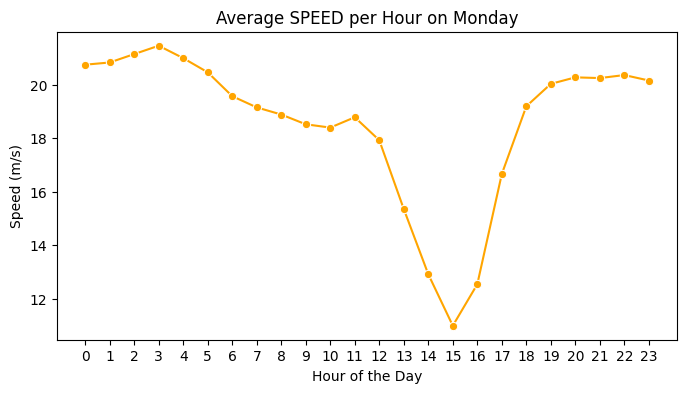

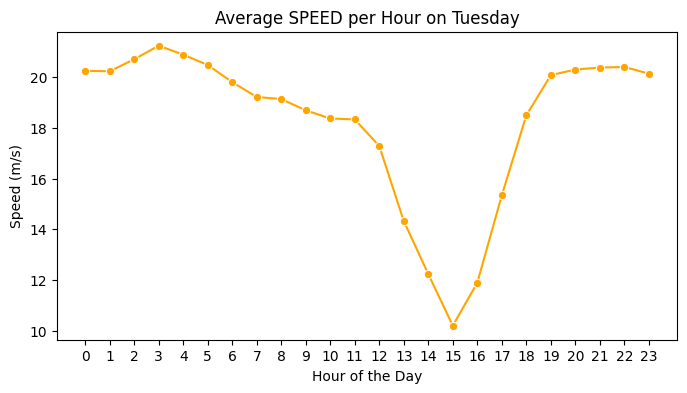

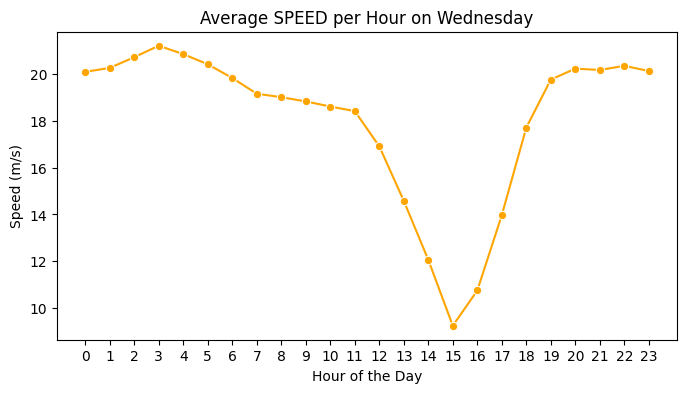

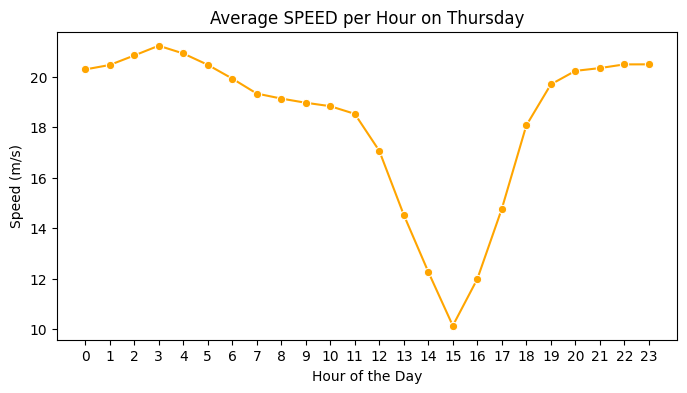

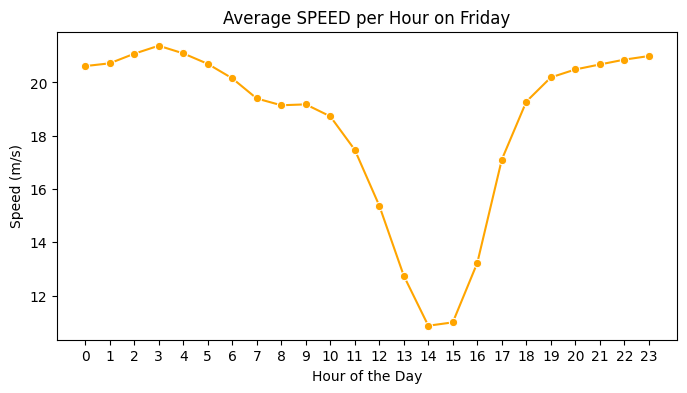

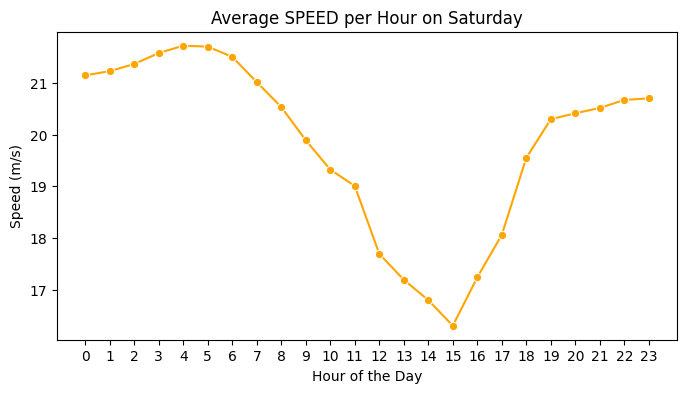

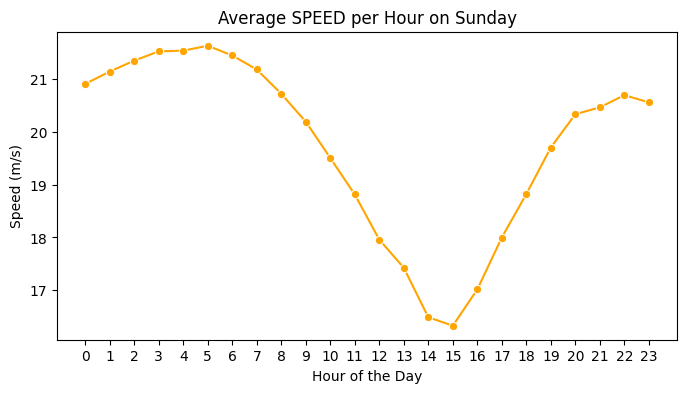

In [24]:
#Average SPEED per hour for each weekday

#Define a mapping from numeric weekday (0=Monday, 6=Sunday) to names
weekday_names = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday",
                 4: "Friday", 5: "Saturday", 6: "Sunday"}

#Loop over each weekday
for day in range(7):
    # Filter the data for the current weekday
    daily_data = data_df[data_df['Weekday'] == day]
    #Group by hour and calculate the mean speed for that hour
    speed_per_hour = daily_data.groupby('Hour')['SPEED_MS_AVG'].mean()
    #Create a figure for the current weekday
    plt.figure(figsize=(8, 4))
    #Plot the average speed per hour as a line plot with markers
    sns.lineplot(
        x=speed_per_hour.index,
        y=speed_per_hour.values,
        marker='o',
        color='orange'
    )
    #Set the plot title with the weekday name
    plt.title(f'Average SPEED per Hour on {weekday_names[day]}')
    #Label the x-axis
    plt.xlabel('Hour of the Day')
    #Label the y-axis
    plt.ylabel('Speed (m/s)')
    #Set x-axis ticks from 0 to 23 (hours of the day)
    plt.xticks(range(0, 24))
    #Display the plot
    plt.show()

###3.3 Analysis of Traffic Flow by Portal and Sensor

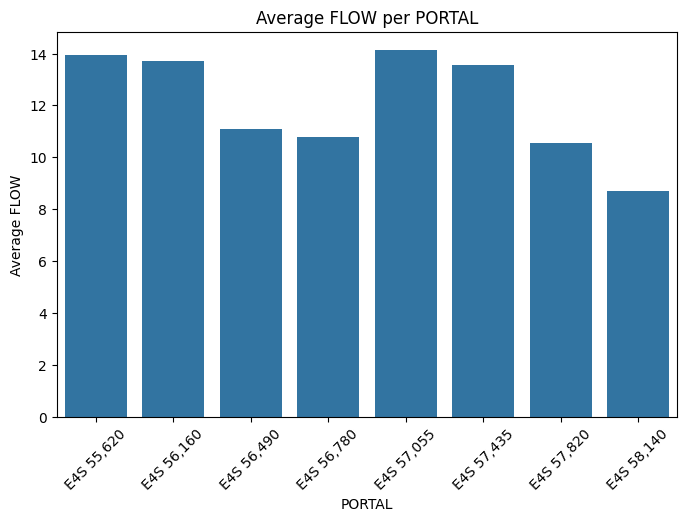

In [25]:
#Average FLOW per PORTAL

#Calculate the average FLOW for each PORTAL
avg_flow_portal = data_df.groupby("PORTAL", observed=False)["FLOW"].mean().sort_values(ascending=False)

#Create a figure with a specified size
plt.figure(figsize=(8,5))

#Plot a bar chart of the average FLOW per PORTAL
sns.barplot(x=avg_flow_portal.index, y=avg_flow_portal.values)

#Rotate x-axis labels to avoid overlap
plt.xticks(rotation=45)

#Set plot title, x-axis label, y-axis label, and display the plot
plt.title("Average FLOW per PORTAL")
plt.ylabel("Average FLOW")
plt.xlabel("PORTAL")
plt.show()

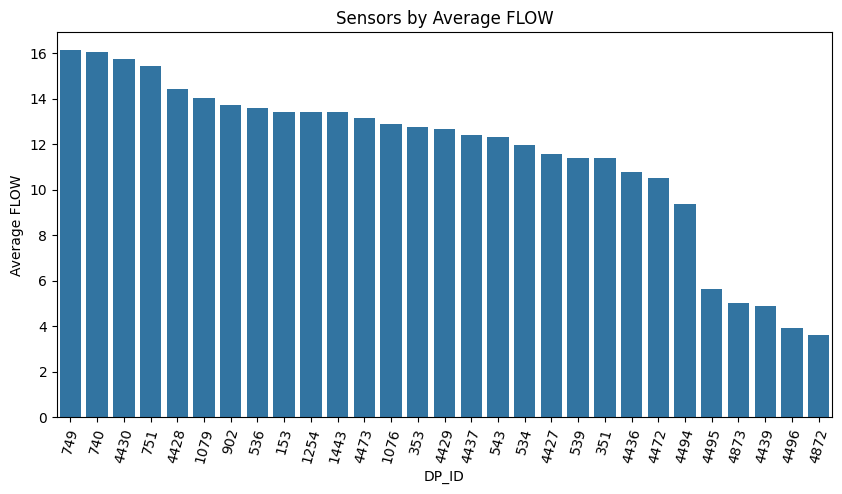

In [26]:
#Average FLOW per sensor

#Calculate the average FLOW for each sensor
avg_flow_sensor = data_df.groupby("DP_ID")["FLOW"].mean().sort_values(ascending=False)

#Create a figure with a specified size
plt.figure(figsize=(10,5))

#Plot a bar chart of the top 15 sensors by average FLOW
#Convert DP_ID to string for better labeling on x-axis
sns.barplot(x=avg_flow_sensor.index.astype(str), y=avg_flow_sensor.values)

#Rotate x-axis labels to avoid overlap
plt.xticks(rotation=75)

#Set plot title, x-axis label, y-axis label, and display the plot
plt.title("Sensors by Average FLOW")
plt.ylabel("Average FLOW")
plt.xlabel("DP_ID")
plt.show()


###3.4 Hourly Flow Patterns for Different Time Aggregations

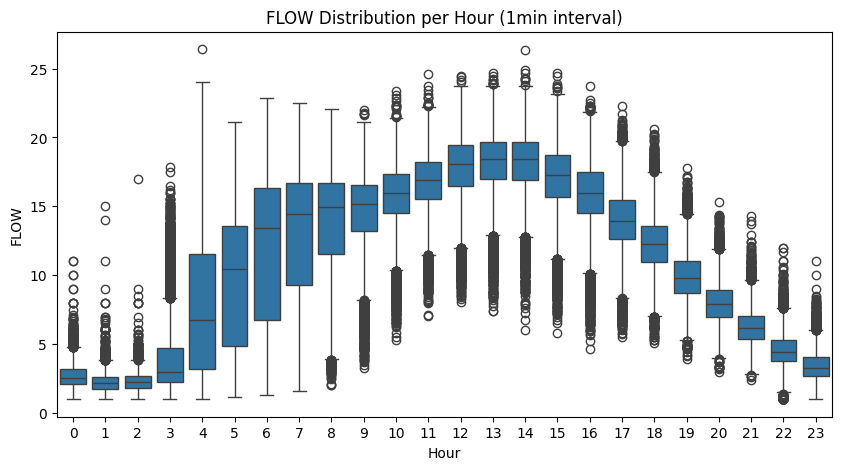

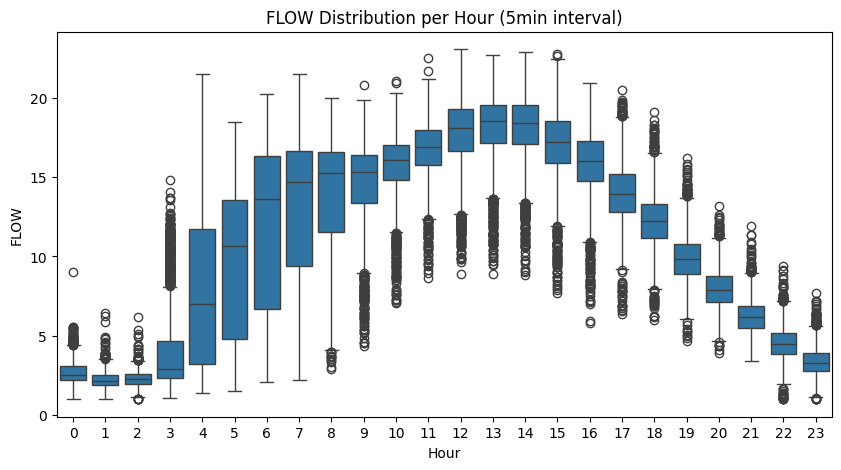

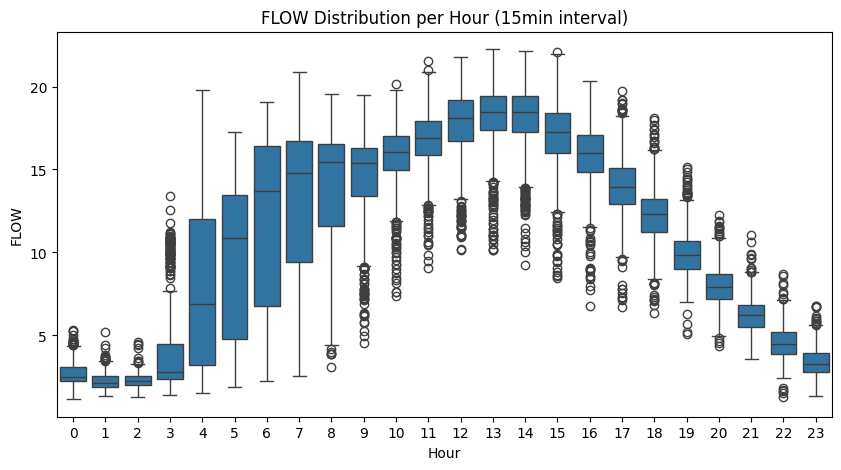

In [27]:
#Code generated with the help of ChatGPT

#Loop through three different time intervals: 1, 5, and 15 minutes
for interval in ['1min', '5min', '15min']:
    #Resample the data to the current interval and calculate the mean FLOW for each time window
    temp = data_df.resample(interval).mean(numeric_only=True)[['FLOW']]
    #Extract the hour from the datetime index to group FLOW values by hour of the day
    temp['Hour'] = temp.index.hour
    # Create a new figure with a specified size for better visibility
    plt.figure(figsize=(10,5))
    #Create a boxplot showing the distribution of FLOW values for each hour
    sns.boxplot(x='Hour', y='FLOW', data=temp)
    #Add a title indicating which time interval is being analyzed
    plt.title(f'FLOW Distribution per Hour ({interval} interval)')
    #Display the plot
    plt.show()

###3.5 Lag Feature Analysis

In [28]:
#Calculate the correlation between the previous FLOW value and the current FLOW
lag_cols = ["FLOW_previous_5min", "FLOW_previous_10min", "FLOW_previous_15min"]

for col in lag_cols:
    corr = sensor_agg_5min[[col, "FLOW"]].corr().iloc[0,1]
    print(f"Correlation between {col} and current FLOW: {corr:.2f}")

Correlation between FLOW_previous_5min and current FLOW: 0.96
Correlation between FLOW_previous_10min and current FLOW: 0.95
Correlation between FLOW_previous_15min and current FLOW: 0.94


###3.6 Rush Hour and Weekend Analysis

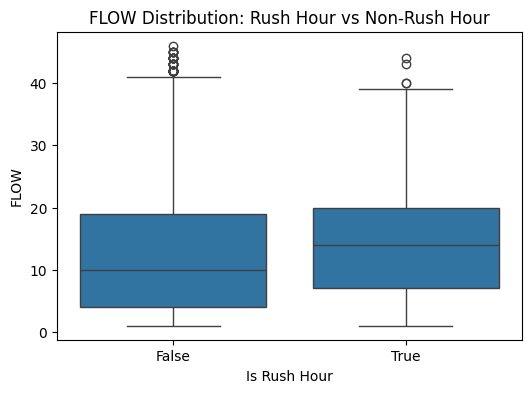

In [29]:
#Create a boxplot to compare the distribution of traffic flow (FLOW) between rush hour and non-rush hour periods

#Set the figure size
plt.figure(figsize=(6,4))

#Draw boxplot: x = rush hour flag, y = FLOW values
sns.boxplot(x="Is_rushhour", y="FLOW", data=data_df)

#Set plot title, x-axis label, y-axis label, and display the plot
plt.title("FLOW Distribution: Rush Hour vs Non-Rush Hour")
plt.xlabel("Is Rush Hour")
plt.ylabel("FLOW")
plt.show()


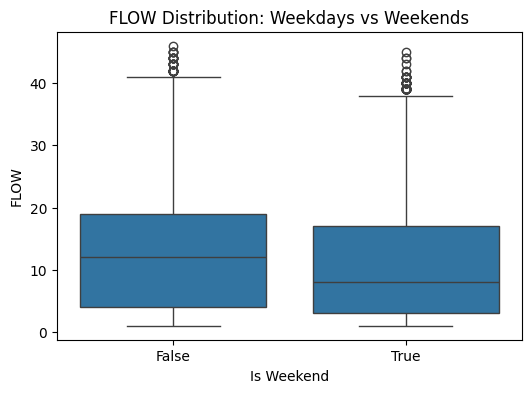

In [30]:
#Create a boxplot to compare the distribution of traffic flow between weekdays and weekends

#Set the figure size
plt.figure(figsize=(6,4))

#Draw boxplot: x = weekend flag, y = FLOW values
sns.boxplot(x="Is_weekend", y="FLOW", data=data_df)

#Set plot title, x-axis label, y-axis label, and display the plot
plt.title("FLOW Distribution: Weekdays vs Weekends")
plt.xlabel("Is Weekend")
plt.ylabel("FLOW")
plt.show()

##4. Prepare for Modeling

In [31]:
#Reset the index so that 'Datetime' becomes a regular column instead of the index
data_df = data_df.reset_index()

#Separate Datetime into Date and Time
data_df['Date'] = data_df['Datetime'].dt.date
data_df['Time'] = data_df['Datetime'].dt.time


In [32]:
#Include Hour and Minute_of_day in the aggregation so we can filter later
aggregate_over_5_min = data_df.groupby(['Date', 'Interval_5', 'Hour', 'Minute_of_day', 'Weekday']).agg(
    FLOW=('FLOW', 'sum'),
    SPEED_MS_AVG=('SPEED_MS_AVG', 'mean')
).reset_index()

#Create lag features
aggregate_over_5_min['previous_flow'] = aggregate_over_5_min.groupby('Date')['FLOW'].shift(1)
aggregate_over_5_min['previous_speed'] = aggregate_over_5_min.groupby('Date')['SPEED_MS_AVG'].shift(1)

#Drop first row per day
aggregate_over_5_min = aggregate_over_5_min.dropna()

#Display the Dataframe
aggregate_over_5_min

,Date,Interval_5,Hour,Minute_of_day,Weekday,FLOW,SPEED_MS_AVG,previous_flow,previous_speed
1,2021-06-01,0,0,1,1,29.0,20.906250,22.0,21.295455
2,2021-06-01,0,0,2,1,32.0,21.353529,29.0,20.906250
3,2021-06-01,0,0,3,1,37.0,20.825556,32.0,21.353529
4,2021-06-01,0,0,4,1,32.0,19.840500,37.0,20.825556
5,2021-06-01,1,0,5,1,22.0,20.206429,32.0,19.840500
...,...,...,...,...,...,...,...,...,...
307861,2021-12-31,287,23,1435,4,153.0,21.120741,192.0,20.393200
307862,2021-12-31,287,23,1436,4,136.0,20.149200,153.0,21.120741
307863,2021-12-31,287,23,1437,4,174.0,20.503462,136.0,20.149200
307864,2021-12-31,287,23,1438,4,150.0,19.885200,174.0,20.503462


## 5. Modeling

In [33]:
#Import StandardScaler to normalize/scale features for models
from sklearn.preprocessing import StandardScaler

#Import LinearRegression model from scikit-learn
from sklearn.linear_model import LinearRegression

#Import XGBoost library for gradient boosting regression
import xgboost as xgb

#Import GridSearchCV for hyperparameter tuning and model selection
#Allows testing multiple parameter combinations to find the best performing model
from sklearn.model_selection import GridSearchCV

#Import XGBoost regressor for gradient boosting regression tasks
from xgboost import XGBRegressor

#Import Random Forest Regressor from scikit-learn
from sklearn.ensemble import RandomForestRegressor

#Import evaluation metrics for regression models: MAE, MSE, and R^2
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

###5.1 Rush Hour

In [34]:
#Code generated with the help of ChatGPT

# --------------------------------------------------------
# --- Filter for rush hour (07:30–08:30)
#Select only rows where Minute_of_day is between 7:30 AM (450) and 8:30 AM (510)
rush_hour_data = aggregate_over_5_min[
    (aggregate_over_5_min['Minute_of_day'] >= 7*60 + 30) &
    (aggregate_over_5_min['Minute_of_day'] <= 8*60 + 30)
].copy()

# --------------------------------------------------------
# --- Create rolling 15-minute future target ---
#Define how many 5-min steps ahead we want to predict
num_steps_ahead = 3

#Loop through each step to create separate columns for each 5-min future FLOW
for i in range(1, num_steps_ahead+1):
    rush_hour_data[f'FLOW_{i*5}min_ahead'] = rush_hour_data.groupby('Date')['FLOW'].shift(-i)

# --------------------------------------------------------
# --- Create a single target for the full 15-minute interval ---
#Average the three 5-min ahead columns to get one target
rush_hour_data['FLOW_next_15min'] = rush_hour_data[
    [f'FLOW_{i*5}min_ahead' for i in range(1, num_steps_ahead+1)]
].mean(axis=1)  # Mean over the three steps

#Remove rows where the new target is NaN (e.g., last intervals of each day)
rush_hour_data = rush_hour_data.dropna(subset=['FLOW_next_15min'])

# --------------------------------------------------------
# --- Define features and target variable ---
features = ['previous_flow', 'previous_speed', 'Minute_of_day', 'Weekday']

#Features (input variables)
X_rush = rush_hour_data[features + ['Date']].copy()

# Target (output variable)
y_rush = rush_hour_data['FLOW_next_15min'].copy()  # Single target

# --------------------------------------------------------
# --- Sort data by date ---
#Ensures chronological order for time-series splitting
X_rush = X_rush.sort_values('Date')
y_rush = y_rush.loc[X_rush.index]

# --------------------------------------------------------
# --- Split 80/20 based on date ---
#Use 80% of dates for training, 20% for testing
split_date = X_rush['Date'].quantile(0.8)

train_mask = X_rush['Date'] <= split_date
test_mask  = X_rush['Date'] > split_date

X_train_rush = X_rush[train_mask].drop(columns=['Date'])  #Drop Date column for modeling
X_test_rush  = X_rush[test_mask].drop(columns=['Date'])
y_train_rush = y_rush[train_mask]
y_test_rush  = y_rush[test_mask]

# --------------------------------------------------------
# --- Scale features ---
#Standardize input features to have mean=0 and std=1 (important for some models)
scaler = StandardScaler()
X_train_rush_scaled = scaler.fit_transform(X_train_rush)  #Fit scaler on training data
X_test_rush_scaled  = scaler.transform(X_test_rush)       #Apply same scaling to test data


####Linear Regression

In [35]:
#Code from: https://www.datacamp.com/tutorial/sklearn-linear-regression?dc_referrer=https%3A%2F%2Fwww.google.com%2F

#Initialize and train Linear Regression model
model_rush = LinearRegression()
model_rush.fit(X_train_rush_scaled, y_train_rush)

#Make predictions
y_pred_rush = model_rush.predict(X_test_rush_scaled)

#Evaluate model
mae = mean_absolute_error(y_test_rush, y_pred_rush)
mse = mean_squared_error(y_test_rush, y_pred_rush)
r2 = r2_score(y_test_rush, y_pred_rush)

#Print results
print(f"Linear Regression - Mean Absolute Error: {mae:.2f}")
print(f"Linear Regression - Mean Squared Error: {mse:.2f}")
print(f"Linear Regression - R-squared: {r2:.3f}")



Linear Regression - Mean Absolute Error: 29.32
Linear Regression - Mean Squared Error: 1323.72
Linear Regression - R-squared: 0.939


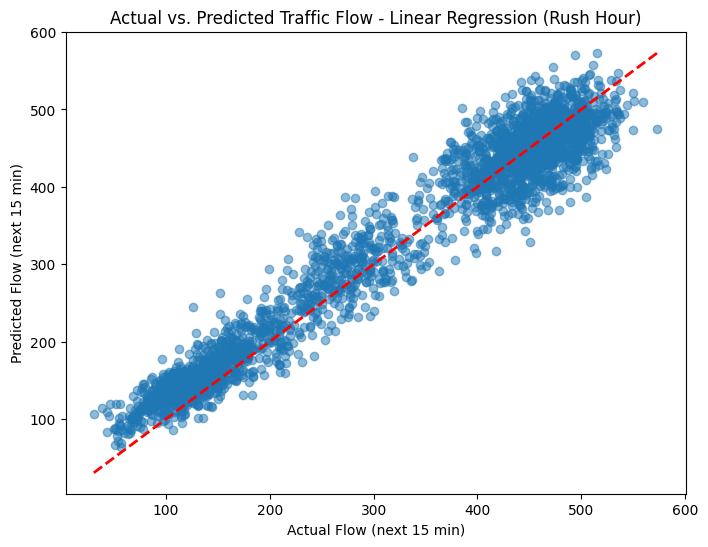

In [36]:
#Create a scatter plot to compare actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test_rush, y_pred_rush, alpha=0.5)  #Each point represents one test sample

#Add labels and a title
plt.xlabel("Actual Flow (next 15 min)")
plt.ylabel("Predicted Flow (next 15 min)")
plt.title("Actual vs. Predicted Traffic Flow - Linear Regression (Rush Hour)")

#Add a diagonal line representing perfect predictions
plt.plot([y_test_rush.min(), y_test_rush.max()],
         [y_test_rush.min(), y_test_rush.max()],
         linestyle='--', color='red', lw=2)

#Display the plot
plt.show()

####XGBoost

In [37]:
#Code from https://machinelearningmastery.com/xgboost-for-regression/

#Define the grid of hyperparameters to search over
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.3],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.6, 0.8, 1]
}

#Create the GridSearchCV object with 3-fold cross-validation
grid_search = GridSearchCV(XGBRegressor(), param_grid, cv=3, verbose=2, n_jobs=-1)

#Fit the grid search to the scaled training data
grid_search.fit(X_train_rush_scaled, y_train_rush)

#Get the best hyperparameters from the grid search
best_params = grid_search.best_params_
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", grid_search.best_score_)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best Cross-Validation Score: 0.8968645463371923


In [ ]:
#Train final XGBoost model using the best parameters
best_xgb = XGBRegressor(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    subsample=best_params['subsample']
)

#Fit the final model to the scaled training data
best_xgb.fit(X_train_rush_scaled, y_train_rush)

#Make predictions on the test set
y_pred_rush = best_xgb.predict(X_test_rush_scaled)

#Evaluate the model
mae = mean_absolute_error(y_test_rush, y_pred_rush)
mse = mean_squared_error(y_test_rush, y_pred_rush)
r2  = r2_score(y_test_rush, y_pred_rush)

print(f"XGBoost - Mean Absolute Error: {mae:.2f}")
print(f"XGBoost - Mean Squared Error: {mse:.2f}")
print(f"XGBoost - R-squared: {r2:.3f}")

XGBoost - Mean Absolute Error: 28.11
XGBoost - Mean Squared Error: 1264.89
XGBoost - R-squared: 0.942


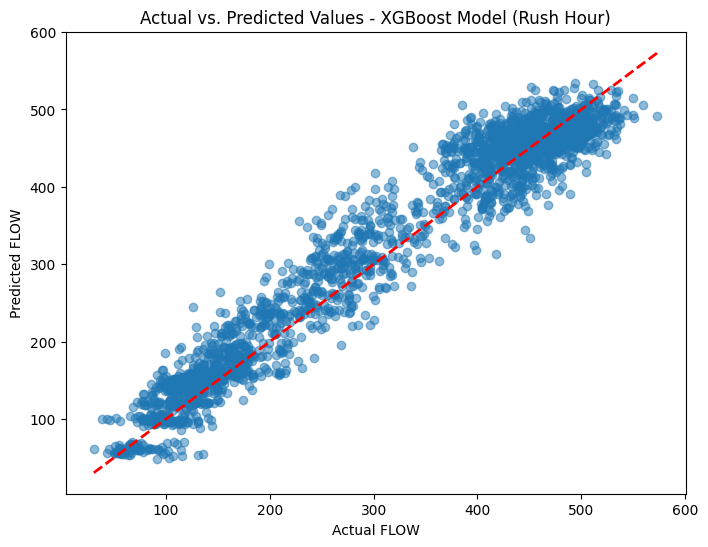

In [ ]:
#Create a scatter plot to compare actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test_rush, y_pred_rush, alpha=0.5)  #Each point represents one test sample

#Add labels and a title
plt.xlabel("Actual FLOW")
plt.ylabel("Predicted FLOW")
plt.title("Actual vs. Predicted Values - XGBoost Model (Rush Hour)")

#Add a diagonal line representing perfect predictions
plt.plot([min(y_test_rush), max(y_test_rush)],
         [min(y_test_rush), max(y_test_rush)],
         linestyle='--', color='red', lw=2)

#Display the plot
plt.show()

####Random Forest

In [ ]:
#Code from: https://www.geeksforgeeks.org/machine-learning/random-forest-regression-in-python/

#Initialize Random Forest Regressor
rf_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42
)

#Train the model
rf_model.fit(X_train_rush_scaled, y_train_rush)

#Make predictions
y_pred_rush_rf = rf_model.predict(X_test_rush_scaled)

#Evaluate the model
mae_rf = mean_absolute_error(y_test_rush, y_pred_rush_rf)
mse_rf = mean_squared_error(y_test_rush, y_pred_rush_rf)
r2_rf  = r2_score(y_test_rush, y_pred_rush_rf)

print(f"Random Forest - Mean Absolute Error: {mae_rf:.2f}")
print(f"Random Forest - Mean Squared Error: {mse_rf:.2f}")
print(f"Random Forest - R-squared: {r2_rf:.3f}")


Random Forest - Mean Absolute Error: 30.74
Random Forest - Mean Squared Error: 1524.04
Random Forest - R-squared: 0.930


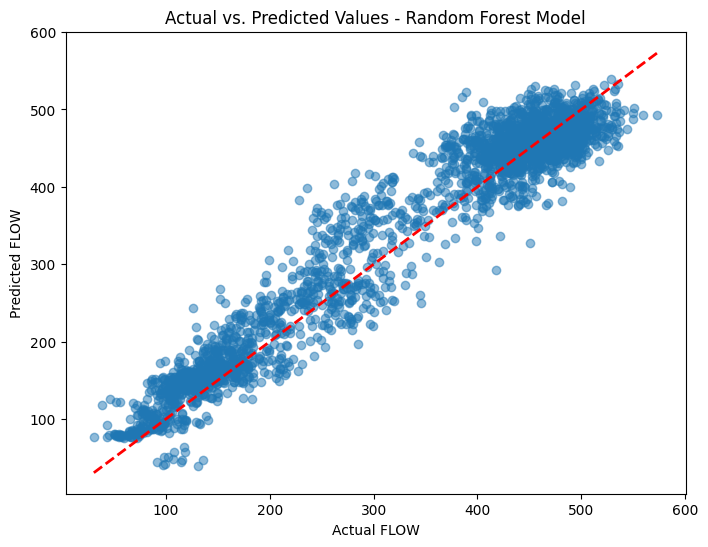

In [ ]:
#Each point represents one test sample
plt.figure(figsize=(8, 6))
plt.scatter(y_test_rush, y_pred_rush_rf, alpha=0.5)  #Each point represents one test sample

#Add labels and title
plt.xlabel("Actual FLOW")
plt.ylabel("Predicted FLOW")
plt.title("Actual vs. Predicted Values - Random Forest Model")

#Add a diagonal line representing perfect predictions
plt.plot([min(y_test_rush), max(y_test_rush)], [min(y_test_rush), max(y_test_rush)],
         linestyle='--', color='red', lw=2)

#Display the plot
plt.show()

###5.2 Off-Peak Hours

In [ ]:
#Code generated with the help of ChatGPT

# --------------------------------------------------------
# --- Filter for off-peak hours (outside 07:30–08:30) ---
#Select only rows where Minute_of_day is outside 7:30 AM (450) to 8:30 AM (510)
off_peak_data = aggregate_over_5_min[
    (aggregate_over_5_min['Minute_of_day'] < 7*60 + 30) |
    (aggregate_over_5_min['Minute_of_day'] > 8*60 + 30)
].copy()

# --------------------------------------------------------
# --- Create rolling 15-minute future target ---
#Define how many 5-min steps ahead we want to predict
num_steps_ahead = 3

#Loop through each step to create separate columns for each 5-min future FLOW
for i in range(1, num_steps_ahead+1):
    off_peak_data[f'FLOW_{i*5}min_ahead'] = off_peak_data.groupby('Date')['FLOW'].shift(-i)

# --------------------------------------------------------
# --- Create a single target for the full 15-minute interval ---
#Average the three 5-min ahead columns to get one target
off_peak_data['FLOW_next_15min'] = off_peak_data[
    [f'FLOW_{i*5}min_ahead' for i in range(1, num_steps_ahead+1)]
].mean(axis=1)

#Remove rows where the new target is NaN (e.g., last intervals of each day)
off_peak_data = off_peak_data.dropna(subset=['FLOW_next_15min'])

# --------------------------------------------------------
# --- Define features and target variable ---
features = ['previous_flow', 'previous_speed', 'Minute_of_day', 'Weekday']

# Features (input variables)
X_off_peak = off_peak_data[features + ['Date']].copy()

# Target (output variable)
y_off_peak = off_peak_data['FLOW_next_15min'].copy()  #Single target

# --------------------------------------------------------
# --- Sort data by date ---
#Ensures chronological order for time-series splitting
X_off_peak = X_off_peak.sort_values('Date')
y_off_peak = y_off_peak.loc[X_off_peak.index]

# --------------------------------------------------------
# --- Split 80/20 based on date ---
#Use 80% of dates for training, 20% for testing
split_date = X_off_peak['Date'].quantile(0.8)

train_mask = X_off_peak['Date'] <= split_date
test_mask  = X_off_peak['Date'] > split_date

X_train_off_peak = X_off_peak[train_mask].drop(columns=['Date'])  #Drop Date column for modeling
X_test_off_peak  = X_off_peak[test_mask].drop(columns=['Date'])
y_train_off_peak = y_off_peak[train_mask]
y_test_off_peak  = y_off_peak[test_mask]

# --------------------------------------------------------
# --- Scale features ---
#Standardize input features to have mean=0 and std=1
scaler = StandardScaler()
X_train_off_peak_scaled = scaler.fit_transform(X_train_off_peak)
X_test_off_peak_scaled  = scaler.transform(X_test_off_peak)

####Linear Regression

In [ ]:
#Code from: https://www.datacamp.com/tutorial/sklearn-linear-regression?dc_referrer=https%3A%2F%2Fwww.google.com%2F

#Initialize and train Linear Regression model
model_off_peak = LinearRegression()
model_off_peak.fit(X_train_off_peak_scaled, y_train_off_peak)

#Make predictions
y_pred_off_peak = model_off_peak.predict(X_test_off_peak_scaled)

#Evaluate model
mae_off_peak = mean_absolute_error(y_test_off_peak, y_pred_off_peak)
mse_off_peak = mean_squared_error(y_test_off_peak, y_pred_off_peak)
r2_off_peak  = r2_score(y_test_off_peak, y_pred_off_peak)

#Print results
print(f"Linear Regression - Mean Absolute Error: {mae_off_peak:.2f}")
print(f"Linear Regression - Mean Squared Error: {mse_off_peak:.2f}")
print(f"Linear Regression - R-squared: {r2_off_peak:.3f}")


Linear Regression - Mean Absolute Error: 25.43
Linear Regression - Mean Squared Error: 1196.01
Linear Regression - R-squared: 0.963


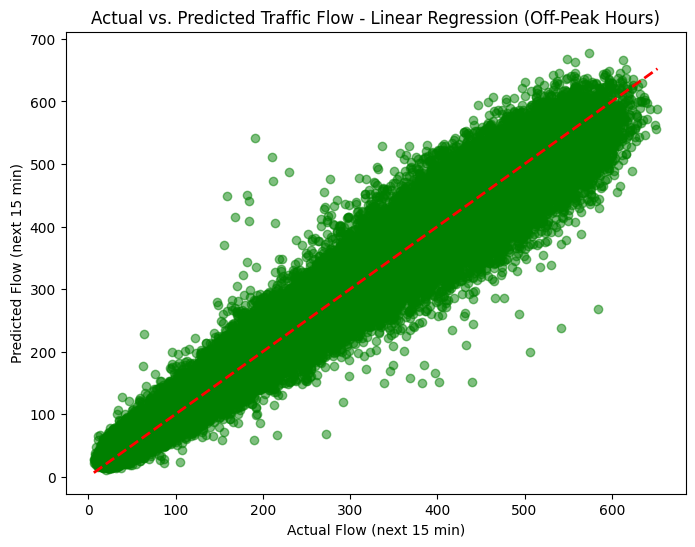

In [ ]:
#Create a scatter plot to compare actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test_off_peak, y_pred_off_peak, alpha=0.5, color='green')  #Each point represents one test sample

#Add labels and a title
plt.xlabel("Actual Flow (next 15 min)")
plt.ylabel("Predicted Flow (next 15 min)")
plt.title("Actual vs. Predicted Traffic Flow - Linear Regression (Off-Peak Hours)")

#Add a diagonal line representing perfect predictions
plt.plot([y_test_off_peak.min(), y_test_off_peak.max()],
         [y_test_off_peak.min(), y_test_off_peak.max()],
         linestyle='--', color='red', lw=2)

#Display the plot
plt.show()

####XGBoost

In [ ]:
#Code from https://machinelearningmastery.com/xgboost-for-regression/

#Define the grid of hyperparameters to search over
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.3],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.6, 0.8, 1]
}

#Create the GridSearchCV object with 3-fold cross-validation
grid_search_off_peak = GridSearchCV(
    XGBRegressor(random_state=42),
    param_grid,
    cv=3,
    verbose=2,
    n_jobs=-1
)

#Fit the grid search to the scaled training data
grid_search_off_peak.fit(X_train_off_peak_scaled, y_train_off_peak)

#Get the best hyperparameters from the grid search
best_params_off_peak = grid_search_off_peak.best_params_
print("Best Parameters (Off-Peak):", best_params_off_peak)
print("Best Cross-Validation Score (Off-Peak):", grid_search_off_peak.best_score_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters (Off-Peak): {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.6}
Best Cross-Validation Score (Off-Peak): 0.970531578101678


In [ ]:
#Train Final XGBoost Model
best_xgb_off_peak = XGBRegressor(
    n_estimators=best_params_off_peak['n_estimators'],
    learning_rate=best_params_off_peak['learning_rate'],
    max_depth=best_params_off_peak['max_depth'],
    subsample=best_params_off_peak['subsample'],
    random_state=42
)

#Fit the final model to the scaled training data
best_xgb_off_peak.fit(X_train_off_peak_scaled, y_train_off_peak)

#Make Predictions and Evaluate
y_pred_off_peak = best_xgb_off_peak.predict(X_test_off_peak_scaled)

#Evaluate the model
mae_off_peak = mean_absolute_error(y_test_off_peak, y_pred_off_peak)
mse_off_peak = mean_squared_error(y_test_off_peak, y_pred_off_peak)
r2_off_peak  = r2_score(y_test_off_peak, y_pred_off_peak)

print(f"XGBoost - Mean Absolute Error: {mae_off_peak:.2f}")
print(f"XGBoost - Mean Squared Error: {mse_off_peak:.2f}")
print(f"XGBoost - R-squared: {r2_off_peak:.3f}")

XGBoost - Mean Absolute Error: 22.63
XGBoost - Mean Squared Error: 969.31
XGBoost - R-squared: 0.970


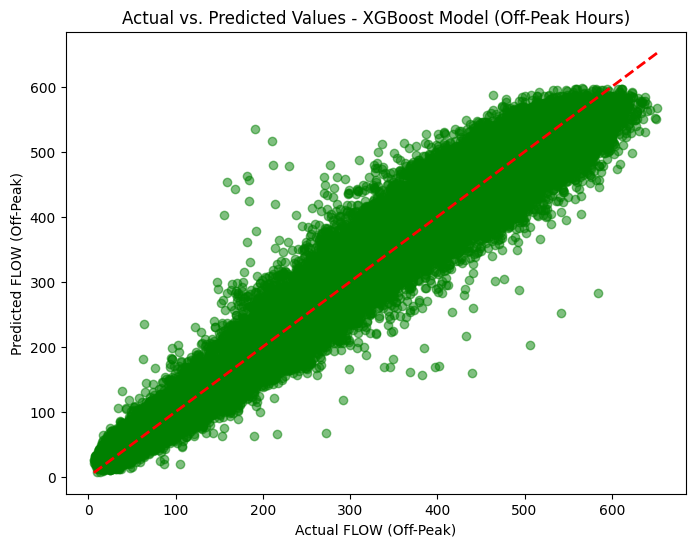

In [ ]:
#Code from the tutorial

#Create a scatter plot to compare actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test_off_peak, y_pred_off_peak, alpha=0.5, color='green')  # Each point represents one test sample

#Add labels and a title
plt.xlabel("Actual FLOW (Off-Peak)")
plt.ylabel("Predicted FLOW (Off-Peak)")
plt.title("Actual vs. Predicted Values - XGBoost Model (Off-Peak Hours)")

#Add a diagonal line representing perfect predictions
plt.plot([y_test_off_peak.min(), y_test_off_peak.max()],
         [y_test_off_peak.min(), y_test_off_peak.max()],
         linestyle='--', color='red', lw=2)

#Display the plot
plt.show()


####Random Forest

In [ ]:
#Code from: https://www.geeksforgeeks.org/machine-learning/random-forest-regression-in-python/

#Initialize Random Forest Regressor
rf_model_off_peak = RandomForestRegressor(
    n_estimators=100,  # fler träd ger ofta bättre resultat
    random_state=42
)

#Train the model
rf_model_off_peak.fit(X_train_off_peak_scaled, y_train_off_peak)

#Make predictions
y_pred_off_peak_rf = rf_model_off_peak.predict(X_test_off_peak_scaled)

#Evaluate the model
mae_off_peak_rf = mean_absolute_error(y_test_off_peak, y_pred_off_peak_rf)
mse_off_peak_rf = mean_squared_error(y_test_off_peak, y_pred_off_peak_rf)
r2_off_peak_rf  = r2_score(y_test_off_peak, y_pred_off_peak_rf)

print(f"Random Forest - Mean Absolute Error: {mae_off_peak_rf:.2f}")
print(f"Random Forest - Mean Squared Error: {mse_off_peak_rf:.2f}")
print(f"Random Forest - R-squared: {r2_off_peak_rf:.3f}")

Random Forest - Mean Absolute Error: 24.37
Random Forest - Mean Squared Error: 1121.74
Random Forest - R-squared: 0.965


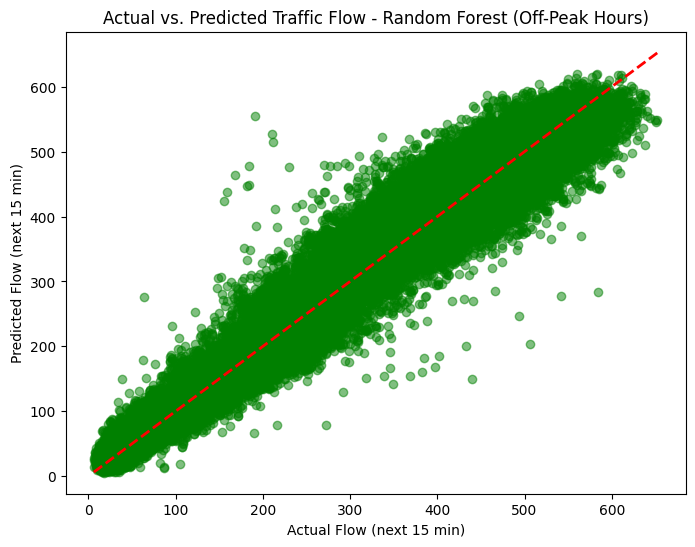

In [ ]:
#Create a scatter plot to compare actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test_off_peak, y_pred_off_peak_rf, alpha=0.5, color='green')  # Each point represents one test sample

#Add labels and title
plt.xlabel("Actual Flow (next 15 min)")
plt.ylabel("Predicted Flow (next 15 min)")
plt.title("Actual vs. Predicted Traffic Flow - Random Forest (Off-Peak Hours)")

#Add a diagonal line representing perfect predictions
plt.plot([y_test_off_peak.min(), y_test_off_peak.max()],
         [y_test_off_peak.min(), y_test_off_peak.max()],
         linestyle='--', color='red', lw=2)

#Display the plot
plt.show()

###5.3 All Hours

In [ ]:
#Code generated with the help of ChatGPT

# --------------------------------------------------------
# --- Use the entire dataset  ---
all_hours_data = aggregate_over_5_min.copy()  #Make a copy to avoid modifying original data

# --------------------------------------------------------
# --- Create rolling 15-minute future target ---
num_steps_ahead = 3  # 3 steps * 5 min = 15 min

#Loop through each step to create separate columns for each 5-min future FLOW
for i in range(1, num_steps_ahead+1):
    all_hours_data[f'FLOW_{i*5}min_ahead'] = all_hours_data.groupby('Date')['FLOW'].shift(-i)

# --------------------------------------------------------
# --- Create a single target for the full 15-minute interval ---
#Take the mean of the three future steps to get one target variable
all_hours_data['FLOW_next_15min'] = all_hours_data[
    [f'FLOW_{i*5}min_ahead' for i in range(1, num_steps_ahead+1)]
].mean(axis=1)

#Drop rows with NaN in the target (last intervals of each day)
all_hours_data = all_hours_data.dropna(subset=['FLOW_next_15min'])

# --------------------------------------------------------
# --- Define features and target variable ---
features = ['previous_flow', 'previous_speed', 'Minute_of_day', 'Weekday']

#Input features
X_all = all_hours_data[features + ['Date']].copy()  # Keep Date for splitting
#Output target
y_all = all_hours_data['FLOW_next_15min'].copy()    # Single 15-min target

# --------------------------------------------------------
# --- Sort data by date ---
#Ensures chronological order for time-series splitting
X_all = X_all.sort_values('Date')
y_all = y_all.loc[X_all.index]

# --------------------------------------------------------
# --- Split 80/20 based on date ---
#Use 80% of dates for training, 20% for testing
split_date = X_all['Date'].quantile(0.8)

train_mask = X_all['Date'] <= split_date
test_mask  = X_all['Date'] > split_date

#Drop Date column after splitting
X_train_all = X_all[train_mask].drop(columns=['Date'])
X_test_all  = X_all[test_mask].drop(columns=['Date'])
y_train_all = y_all[train_mask]
y_test_all  = y_all[test_mask]

# --------------------------------------------------------
# --- Scale features ---
#Standardize input features to have mean=0 and std=1 (important for models like XGBoost)
scaler = StandardScaler()
X_train_all_scaled = scaler.fit_transform(X_train_all)  #Fit scaler on training data
X_test_all_scaled  = scaler.transform(X_test_all)       #Apply same scaling to test data


####Linear Regression

In [ ]:
#Code from: https://www.datacamp.com/tutorial/sklearn-linear-regression?dc_referrer=https%3A%2F%2Fwww.google.com%2F

#Initialize and train Linear Regression model
model_all = LinearRegression()
model_all.fit(X_train_all_scaled, y_train_all)

#Make predictions
y_pred_all = model_all.predict(X_test_all_scaled)

#Evaluate model
mae_all = mean_absolute_error(y_test_all, y_pred_all)
mse_all = mean_squared_error(y_test_all, y_pred_all)
r2_all  = r2_score(y_test_all, y_pred_all)

#Print results
print(f"Linear Regression - Mean Absolute Error: {mae_all:.2f}")
print(f"Linear Regression - Mean Squared Error: {mse_all:.2f}")
print(f"Linear Regression - R-squared: {r2_all:.3f}")


Linear Regression - Mean Absolute Error: 25.53
Linear Regression - Mean Squared Error: 1197.48
Linear Regression - R-squared: 0.963


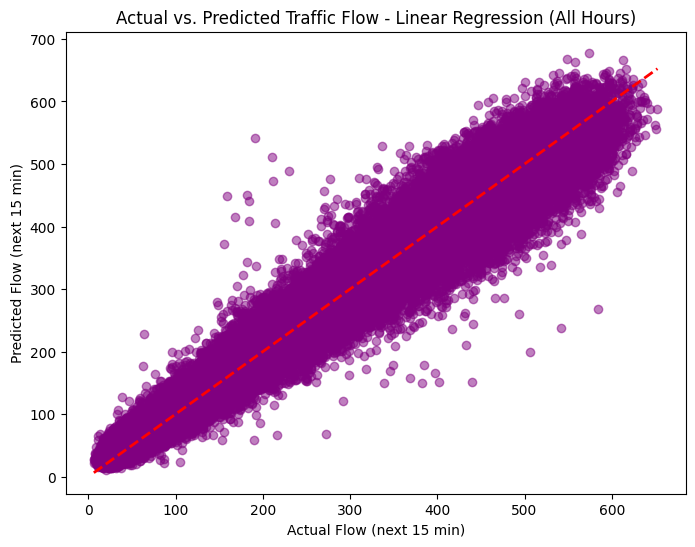

In [ ]:
#Create a scatter plot to compare actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test_all, y_pred_all, alpha=0.5, color='purple')  # Each point represents one test sample

#Add labels and a title
plt.xlabel("Actual Flow (next 15 min)")
plt.ylabel("Predicted Flow (next 15 min)")
plt.title("Actual vs. Predicted Traffic Flow - Linear Regression (All Hours)")

#Add a diagonal line representing perfect predictions
plt.plot([y_test_all.min(), y_test_all.max()],
         [y_test_all.min(), y_test_all.max()],
         linestyle='--', color='red', lw=2)

#Display the plot
plt.show()

####XGBoost

In [ ]:
#Code from https://machinelearningmastery.com/xgboost-for-regression/

#Define the grid of hyperparameters to search over
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.3],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.6, 0.8, 1]
}

#Create the GridSearchCV object with 3-fold cross-validation
grid_search_all = GridSearchCV(XGBRegressor(), param_grid, cv=3, verbose=2, n_jobs=-1)

#Fit the grid search to the scaled training data for all hours
grid_search_all.fit(X_train_all_scaled, y_train_all)

#Get the best hyperparameters from the grid search
best_params_all = grid_search_all.best_params_

print("Best Parameters (All Hours):", best_params_all)
print("Best Cross-Validation Score (All Hours):", grid_search_all.best_score_)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters (All Hours): {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.6}
Best Cross-Validation Score (All Hours): 0.969666753132802


In [ ]:
#Train final XGBoost model using the best parameters
best_xgb_all = XGBRegressor(
    n_estimators=best_params_all['n_estimators'],
    learning_rate=best_params_all['learning_rate'],
    max_depth=best_params_all['max_depth'],
    subsample=best_params_all['subsample']
)

#Fit the final model to the scaled training data
best_xgb_all.fit(X_train_all_scaled, y_train_all)

#Make predictions on the test set
y_pred_all = best_xgb_all.predict(X_test_all_scaled)

#Evaluate the model
mae_all = mean_absolute_error(y_test_all, y_pred_all)
mse_all = mean_squared_error(y_test_all, y_pred_all)
r2_all  = r2_score(y_test_all, y_pred_all)

print(f"XGBoost - Mean Absolute Error: {mae_all:.2f}")
print(f"XGBoost - Mean Squared Error: {mse_all:.2f}")
print(f"XGBoost - R-squared: {r2_all:.3f}")

XGBoost - Mean Absolute Error: 22.78
XGBoost - Mean Squared Error: 976.07
XGBoost - R-squared: 0.969


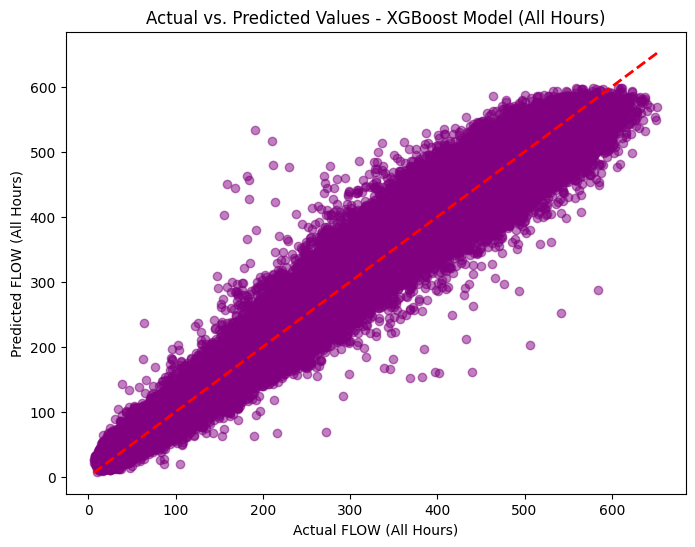

In [ ]:
#Create a scatter plot to compare actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test_all, y_pred_all, alpha=0.5, color='purple')  # Each point represents one test sample

#Add labels and a title
plt.xlabel("Actual FLOW (All Hours)")
plt.ylabel("Predicted FLOW (All Hours)")
plt.title("Actual vs. Predicted Values - XGBoost Model (All Hours)")

#Add a diagonal line representing perfect predictions
plt.plot([y_test_all.min(), y_test_all.max()],
         [y_test_all.min(), y_test_all.max()],
         linestyle='--', color='red', lw=2)

#Display the plot
plt.show()

####Random Forest

In [ ]:
#Code from: https://www.geeksforgeeks.org/machine-learning/random-forest-regression-in-python/

#Initialize Random Forest Regressor
rf_model_all = RandomForestRegressor(
    n_estimators=100,  # fler träd ger ofta bättre resultat
    random_state=42
)

#Train the model
rf_model_all.fit(X_train_all_scaled, y_train_all)

#Make predictions
y_pred_all_rf = rf_model_all.predict(X_test_all_scaled)

#Evaluate the model
mae_all_rf = mean_absolute_error(y_test_all, y_pred_all_rf)
mse_all_rf = mean_squared_error(y_test_all, y_pred_all_rf)
r2_all_rf  = r2_score(y_test_all, y_pred_all_rf)

print(f"Random Forest - Mean Absolute Error: {mae_all_rf:.2f}")
print(f"Random Forest - Mean Squared Error: {mse_all_rf:.2f}")
print(f"Random Forest - R-squared: {r2_all_rf:.3f}")


Random Forest - Mean Absolute Error: 24.60
Random Forest - Mean Squared Error: 1135.15
Random Forest - R-squared: 0.964


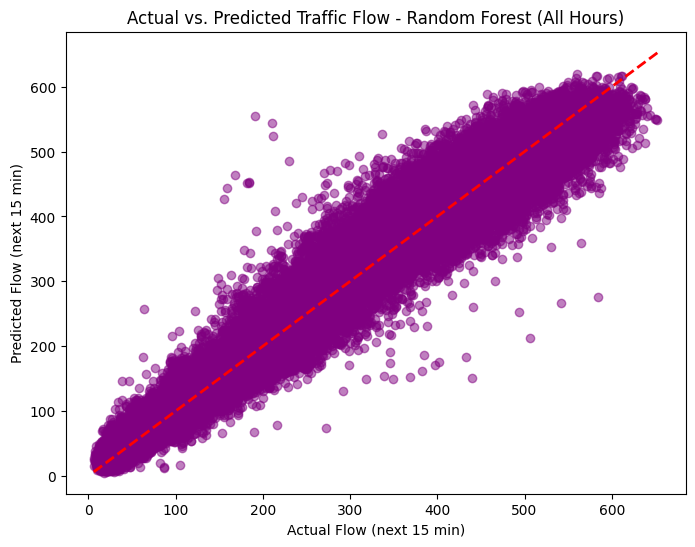

In [ ]:
#Create a scatter plot to compare actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test_all, y_pred_all_rf, alpha=0.5, color='purple')  #Each point represents one test sample

#Add labels and title
plt.xlabel("Actual Flow (next 15 min)")
plt.ylabel("Predicted Flow (next 15 min)")
plt.title("Actual vs. Predicted Traffic Flow - Random Forest (All Hours)")

#Add a diagonal line representing perfect predictions
plt.plot([y_test_all.min(), y_test_all.max()],
         [y_test_all.min(), y_test_all.max()],
         linestyle='--', color='red', lw=2)

#Display the plot
plt.show()


##6. Final Evaluation

###6.1 Prepare the Data

In [ ]:
#Import pandas for data handling and analysis
import pandas as pd
#Import numpy for numerical operations
import numpy as np

#Read the CSV file into a pandas DataFrame, using semicolon as the column separator
df_final = pd.read_csv("final_evaluation_dataset.csv",sep=";")
#Display the contents of the DataFrame
df_final

,DP_ID,PORTAL,Date,Time,Interval_1,Interval_5,Interval_15,Interval_30,Interval_60,SPEED_MS_AVG,FLOW
0,1254,"E4S 55,620",20220101,00:00:00,0,0,0,0,0,23.43,3.0
1,1443,"E4S 57,055",20220101,00:00:00,0,0,0,0,0,22.10,2.0
2,1079,"E4S 56,780",20220101,00:00:00,0,0,0,0,0,19.26,11.0
3,1076,"E4S 55,620",20220101,00:00:00,0,0,0,0,0,20.09,8.0
4,751,"E4S 55,620",20220101,00:00:00,0,0,0,0,0,20.63,12.0
...,...,...,...,...,...,...,...,...,...,...,...
3502601,4429,"E4S 57,435",20220628,23:59:00,1439,287,95,47,23,24.44,3.0
3502602,4430,"E4S 57,435",20220628,23:59:00,1439,287,95,47,23,23.89,6.0
3502603,4472,"E4S 58,140",20220628,23:59:00,1439,287,95,47,23,24.17,1.0
3502604,4872,"E4S 56,780",20220628,23:59:00,1439,287,95,47,23,16.39,4.0


In [ ]:
#Select rows where at least one column has NaN
nan_rows = df_final[df_final.isna().any(axis=1)]

#Number of rows with at least one NaN
print(f"Number of rows with at least one NaN: {len(nan_rows)}")

Number of rows with at least one NaN: 157


In [ ]:
#Count missing values, NaN, in each column
df_final.isna().sum()

,0
DP_ID,0
PORTAL,0
Date,0
Time,0
Interval_1,0
Interval_5,0
Interval_15,0
Interval_30,0
Interval_60,0
SPEED_MS_AVG,0


In [ ]:
#Drop rows with missing FLOW values
df_final = df_final.dropna(subset=['FLOW']).copy()

In [ ]:
#Convert 'Date' from int to datetime for easier extraction of day, month, and weekday
df_final['Date'] = pd.to_datetime(df_final['Date'], format='%Y%m%d')

#Convert 'Time' from object to datetime.time format, making it easier to filter and analyze specific time periods
df_final['Time_dt'] = pd.to_datetime(df_final['Time'], format='%H:%M:%S').dt.time

#Hour of day (0–23)
df_final['Hour'] = pd.to_datetime(df_final['Time'], format='%H:%M:%S').dt.hour

#Minute of day (0–1439)
df_final['Minute_of_day'] = df_final['Hour'] * 60 + pd.to_datetime(df_final['Time'], format='%H:%M:%S').dt.minute

#Weekday (0=Mon, 6=Sun)
df_final['Weekday'] = df_final['Date'].dt.dayofweek

#Weekend flag
df_final['Is_weekend'] = df_final['Weekday'] >= 5

In [ ]:
#Code generated with the help of ChatGPT

#Aggregate over 5-minute intervals
aggregate_over_5_min_final = df_final.groupby(
    ['Date', 'Interval_5', 'Hour', 'Minute_of_day', 'Weekday']
).agg(
    FLOW=('FLOW', 'sum'),
    SPEED_MS_AVG=('SPEED_MS_AVG', 'mean')
).reset_index()

#Create lag features
aggregate_over_5_min_final['previous_flow'] = aggregate_over_5_min_final.groupby('Date')['FLOW'].shift(1)
aggregate_over_5_min_final['previous_speed'] = aggregate_over_5_min_final.groupby('Date')['SPEED_MS_AVG'].shift(1)

#Drop first row per day (NaN after shift)
aggregate_over_5_min_final = aggregate_over_5_min_final.dropna()

#Show result
aggregate_over_5_min_final

,Date,Interval_5,Hour,Minute_of_day,Weekday,FLOW,SPEED_MS_AVG,previous_flow,previous_speed
1,2022-01-01,0,0,1,5,153.0,19.645833,154.0,20.537778
2,2022-01-01,0,0,2,5,157.0,20.478696,153.0,19.645833
3,2022-01-01,0,0,3,5,126.0,21.360870,157.0,20.478696
4,2022-01-01,0,0,4,5,188.0,21.853462,126.0,21.360870
5,2022-01-01,1,0,5,5,169.0,20.732083,188.0,21.853462
...,...,...,...,...,...,...,...,...,...
145218,2022-06-28,287,23,1435,1,92.0,20.116190,58.0,21.355882
145219,2022-06-28,287,23,1436,1,75.0,20.983500,92.0,20.116190
145220,2022-06-28,287,23,1437,1,68.0,21.596190,75.0,20.983500
145221,2022-06-28,287,23,1438,1,61.0,21.020526,68.0,21.596190


###6.2 Modeling

In [ ]:
#Code generated with the help of ChatGPT

# --------------------------------------------------------
# --- Use the entire dataset (all hours, final) ---
all_hours_data_final = aggregate_over_5_min_final.copy()  #Copy to avoid modifying original

# --------------------------------------------------------
# --- Create rolling 15-minute future target ---
num_steps_ahead = 3  # 3 steps * 5 min = 15 min

#Create separate columns for each 5-min future FLOW
for i in range(1, num_steps_ahead+1):
    all_hours_data_final[f'FLOW_{i*5}min_ahead_final'] = all_hours_data_final.groupby('Date')['FLOW'].shift(-i)

# --------------------------------------------------------
# --- Create a single target for the full 15-minute interval ---
#Take the mean of the three future steps
all_hours_data_final['FLOW_next_15min_final'] = all_hours_data_final[
    [f'FLOW_{i*5}min_ahead_final' for i in range(1, num_steps_ahead+1)]
].mean(axis=1)

#Drop rows with NaN in the target
all_hours_data_final = all_hours_data_final.dropna(subset=['FLOW_next_15min_final'])

# --------------------------------------------------------
# --- Define features and target variable ---
features_final = ['previous_flow', 'previous_speed', 'Minute_of_day', 'Weekday']

#Input features
X_all_final = all_hours_data_final[features_final + ['Date']].copy()  #Keep Date for splitting
#Output target
y_all_final = all_hours_data_final['FLOW_next_15min_final'].copy()     #Single 15-min target

# --------------------------------------------------------
# --- Sort data by date ---
X_all_final = X_all_final.sort_values('Date')
y_all_final = y_all_final.loc[X_all_final.index]

# --------------------------------------------------------
# --- Split 80/20 based on date ---
split_date_final = X_all_final['Date'].quantile(0.8)

train_mask_final = X_all_final['Date'] <= split_date_final
test_mask_final  = X_all_final['Date'] > split_date_final

#Drop Date column after splitting
X_train_all_final = X_all_final[train_mask_final].drop(columns=['Date'])
X_test_all_final  = X_all_final[test_mask_final].drop(columns=['Date'])
y_train_all_final = y_all_final[train_mask_final]
y_test_all_final  = y_all_final[test_mask_final]

# --------------------------------------------------------
# --- Scale features ---
#Standardize input features for models like XGBoost
scaler_final = StandardScaler()
X_train_all_final_scaled = scaler_final.fit_transform(X_train_all_final)  #Fit on training data
X_test_all_final_scaled  = scaler_final.transform(X_test_all_final)       #Apply same scaling to test data

In [ ]:
#Code from https://machinelearningmastery.com/xgboost-for-regression/

#Define hyperparameter grid
param_grid_final = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.3],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.6, 0.8, 1]
}

#Create GridSearchCV object with 3-fold cross-validation
grid_search_all_final = GridSearchCV(XGBRegressor(), param_grid_final, cv=3, verbose=2, n_jobs=-1)

#Fit the grid search to the scaled training data for all hours
grid_search_all_final.fit(X_train_all_final_scaled, y_train_all_final)

#Get best hyperparameters
best_params_all_final = grid_search_all_final.best_params_
print("Best Parameters (All Hours):", best_params_all_final)
print("Best Cross-Validation Score (All Hours):", grid_search_all_final.best_score_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters (All Hours): {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}
Best Cross-Validation Score (All Hours): 0.9569913087409242


In [ ]:
#Train final XGBoost model using best parameters
best_xgb_all_final = XGBRegressor(
    n_estimators=best_params_all_final['n_estimators'],
    learning_rate=best_params_all_final['learning_rate'],
    max_depth=best_params_all_final['max_depth'],
    subsample=best_params_all_final['subsample']
)

#Fit final model to training data
best_xgb_all_final.fit(X_train_all_final_scaled, y_train_all_final)

#Make predictions on the test set
y_pred_all_final = best_xgb_all_final.predict(X_test_all_final_scaled)

#Evaluate model
mae_all_final = mean_absolute_error(y_test_all_final, y_pred_all_final)
mse_all_final = mean_squared_error(y_test_all_final, y_pred_all_final)
r2_all_final  = r2_score(y_test_all_final, y_pred_all_final)

print(f"XGBoost - Mean Absolute Error: {mae_all_final:.2f}")
print(f"XGBoost - Mean Squared Error: {mse_all_final:.2f}")
print(f"XGBoost - R-squared: {r2_all_final:.3f}")

XGBoost - Mean Absolute Error: 24.28
XGBoost - Mean Squared Error: 1130.18
XGBoost - R-squared: 0.955


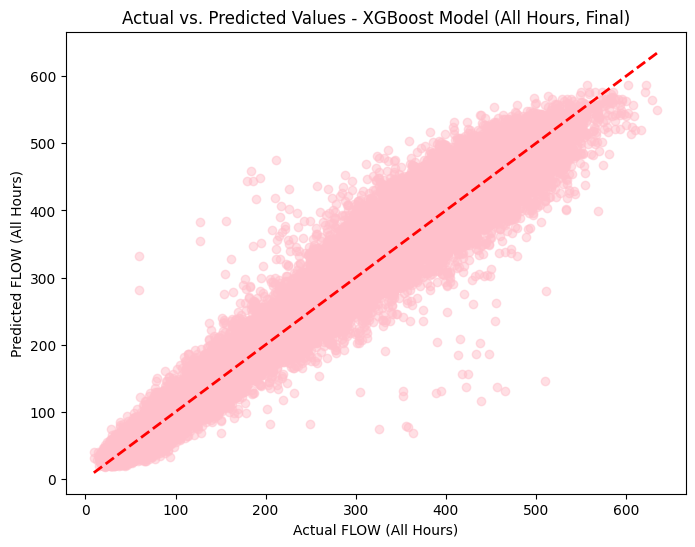

In [ ]:
#Create a scatter plot to compare actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test_all_final, y_pred_all_final, alpha=0.5, color='pink')  # Each point represents one test sample

#Add labels and a title
plt.xlabel("Actual FLOW (All Hours)")
plt.ylabel("Predicted FLOW (All Hours)")
plt.title("Actual vs. Predicted Values - XGBoost Model (All Hours, Final)")

#Add a diagonal line representing perfect predictions
plt.plot([y_test_all_final.min(), y_test_all_final.max()],
         [y_test_all_final.min(), y_test_all_final.max()],
         linestyle='--', color='red', lw=2)

#Display the plot
plt.show()

###6.3 Robustness to Missing Values

####6.3.1 Missing Previous Flow

In [ ]:
#Code generated with the help of ChatGPT

#Copy the test data
X_test_missing_input = X_test_all_final_scaled.copy()
y_test = y_test_all_final.copy()

#Remove 5% of previous_flow values
np.random.seed(42)
n_missing = int(0.05 * X_test_missing_input.shape[0])

missing_indices = np.random.choice(X_test_missing_input.shape[0], size=n_missing, replace=False)
X_test_missing_input[missing_indices, 0] = np.nan  # Set previous_flow to NaN

#Fill missing values with mean from training data
col_mean = np.nanmean(X_train_all_final_scaled[:, 0])
X_test_missing_input[np.isnan(X_test_missing_input[:, 0]), 0] = col_mean

#Make predictions
y_pred_missing_input = best_xgb_all_final.predict(X_test_missing_input)

#Evaluate
mae_missing = mean_absolute_error(y_test, y_pred_missing_input)
mse_missing = mean_squared_error(y_test, y_pred_missing_input)
r2_missing  = r2_score(y_test, y_pred_missing_input)

print(f"MAE with 5% missing previous_flow: {mae_missing:.2f}")
print(f"MSE with 5% missing previous_flow: {mse_missing:.2f}")
print(f"R2 with 5% missing previous_flow: {r2_missing:.3f}")


MAE with 5% missing previous_flow: 29.32
MSE with 5% missing previous_flow: 2124.83
R2 with 5% missing previous_flow: 0.915


In [ ]:
#Code generated with the help of ChatGPT

#Copy the test data
X_test_missing_input = X_test_all_final_scaled.copy()
y_test = y_test_all_final.copy()

#Suppose we want to randomly remove 10% of the previous_flow values
np.random.seed(42)  # For reproducibility
n_missing = int(0.1 * X_test_missing_input.shape[0])

#Randomly select row indices for missing data
missing_indices = np.random.choice(X_test_missing_input.shape[0], size=n_missing, replace=False)

#Assume previous_flow is the first column (adjust index if needed)
X_test_missing_input[missing_indices, 0] = np.nan  # Set previous_flow to NaN

#Fill missing values with mean of training data (simple imputation)
col_mean = np.nanmean(X_train_all_final_scaled[:, 0])  #Mean of previous_flow in training
X_test_missing_input[np.isnan(X_test_missing_input[:, 0]), 0] = col_mean

#Make predictions using the model
y_pred_missing_input = best_xgb_all_final.predict(X_test_missing_input)

#Evaluate performance
mae_missing = mean_absolute_error(y_test, y_pred_missing_input)
mse_missing = mean_squared_error(y_test, y_pred_missing_input)
r2_missing  = r2_score(y_test, y_pred_missing_input)

print(f"MAE with 10% missing previous_flow: {mae_missing:.2f}")
print(f"MSE with 10% missing previous_flow: {mse_missing:.2f}")
print(f"R2 with 10% missing previous_flow: {r2_missing:.3f}")

MAE with 10% missing previous_flow: 34.47
MSE with 10% missing previous_flow: 3145.86
R2 with 10% missing previous_flow: 0.873


####6.3.2 Missing Previous Speed

In [ ]:
#Code generated with the help of ChatGPT

#Copy the test data
X_test_missing_speed = X_test_all_final_scaled.copy()
y_test = y_test_all_final.copy()

#Remove 5% of previous_speed values
np.random.seed(42)
n_missing = int(0.05 * X_test_missing_speed.shape[0])

missing_indices = np.random.choice(X_test_missing_speed.shape[0], size=n_missing, replace=False)
X_test_missing_speed[missing_indices, 1] = np.nan  # Set previous_speed to NaN

#Fill missing values with mean from training data
col_mean = np.nanmean(X_train_all_final_scaled[:, 1])
X_test_missing_speed[np.isnan(X_test_missing_speed[:, 1]), 0] = col_mean

#Make predictions
y_pred_missing_speed = best_xgb_all_final.predict(X_test_missing_speed)

#Evaluate
mae_missing_speed = mean_absolute_error(y_test, y_pred_missing_speed)
mse_missing_speed = mean_squared_error(y_test, y_pred_missing_speed)
r2_missing_speed  = r2_score(y_test, y_pred_missing_speed)

print(f"MAE with 5% missing previous_speed: {mae_missing_speed:.2f}")
print(f"MSE with 5% missing previous_speed: {mse_missing_speed:.2f}")
print(f"R2 with 5% missing previous_speed: {r2_missing_speed:.3f}")


MAE with 5% missing previous_speed: 29.36
MSE with 5% missing previous_speed: 2135.85
R2 with 5% missing previous_speed: 0.914


In [ ]:
#Code generated with the help of ChatGPT

#Copy the test data
X_test_missing_speed = X_test_all_final_scaled.copy()
y_test = y_test_all_final.copy()

#Remove 10% of previous_speed values
np.random.seed(42)
n_missing = int(0.10 * X_test_missing_speed.shape[0])

missing_indices = np.random.choice(X_test_missing_speed.shape[0], size=n_missing, replace=False)
X_test_missing_speed[missing_indices, 1] = np.nan  # Set previous_speed to NaN

#Fill missing values with mean from training data
col_mean = np.nanmean(X_train_all_final_scaled[:, 1])
X_test_missing_speed[np.isnan(X_test_missing_speed[:, 1]), 1] = col_mean

#Make predictions
y_pred_missing_speed = best_xgb_all_final.predict(X_test_missing_speed)

#Evaluate
mae_missing_speed = mean_absolute_error(y_test, y_pred_missing_speed)
mse_missing_speed = mean_squared_error(y_test, y_pred_missing_speed)
r2_missing_speed  = r2_score(y_test, y_pred_missing_speed)

print(f"MAE with 10% missing previous_speed: {mae_missing_speed:.2f}")
print(f"MSE with 10% missing previous_speed: {mse_missing_speed:.2f}")
print(f"R2 with 10% missing previous_speed: {r2_missing_speed:.3f}")

MAE with 10% missing previous_speed: 24.27
MSE with 10% missing previous_speed: 1129.52
R2 with 10% missing previous_speed: 0.955
